# Importing Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import seaborn as sns


import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

# Functions

In [2]:
def rmsle(y, pred):
    log_y    = np.log1p(y)
    log_pred = np.log1p(pred)
    rmsle = np.sqrt(np.mean((log_y-log_pred)**2.))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_error(y, pred, show=True):
    rmsle_val = rmsle(y, pred)
    rmse_val  = rmse(y, pred)
    mae_val   = mean_absolute_error(y, pred)
    if show:
        print('RMSLE: {0:.4f}'.format(rmsle_val), end=" | ")
        print('RMSE : {0:.4f}'.format(rmse_val), end=" | ")
        print('MAE  : {0:.4f}'.format(mae_val))
    return rmsle_val, rmse_val, mae_val

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            scoring='neg_mean_squared_error', 
                                                            train_sizes=train_sizes)
        
    train_scores = np.sqrt(-1*train_scores)
    test_scores  = np.sqrt(-1*test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [4]:
def grid_search(estimator, params, X, y, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1):

    grid_reg = GridSearchCV(estimator, param_grid=params, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_reg.fit(X, y)

    grid_best_socre = np.sqrt(-1*grid_reg.best_score_)
    print(grid_reg.best_params_, grid_best_socre)
    
    return grid_reg

In [5]:
def get_top_bottom_coef(model, X_features, n):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

In [6]:
def visualize_coefficient(model, X_features, n=10, figsize=(8,10)):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 

    # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
    coef_high, coef_low = get_top_bottom_coef(model, X_features, n)
    coef_concat = pd.concat( [coef_high , coef_low] )
    # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
    ax.set_title(model.__class__.__name__+' Coeffiecents', size=12)
    #ax.tick_params(axis="y",direction="in", pad=-120)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
    sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=ax)

# Loading Train and Test Sets

In [7]:
train = pd.read_csv('./input/train.csv', index_col='id')
test  = pd.read_csv('./input/test.csv', index_col='id')

# Information on train and test

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 1 to 499999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 499995
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    200000 non-null  object 
 1   cat1    200000 non-null  object 
 2   cat2    200000 non-null  object 
 3   cat3    200000 non-null  object 
 4   cat4    200000 non-null  object 
 5   cat5    200000 non-null  object 
 6   cat6    200000 non-null  object 
 7   cat7    200000 non-null  object 
 8   cat8    200000 non-null  object 
 9   cat9    200000 non-null  object 
 10  cont0   200000 non-null  float64
 11  cont1   200000 non-null  float64
 12  cont2   200000 non-null  float64
 13  cont3   200000 non-null  float64
 14  cont4   200000 non-null  float64
 15  cont5   200000 non-null  float64
 16  cont6   200000 non-null  float64
 17  cont7   200000 non-null  float64
 18  cont8   200000 non-null  float64
 19  cont9   200000 non-null  float64
 20  cont10  200000 non-null  float64
 21  cont11  20

<AxesSubplot:xlabel='target'>

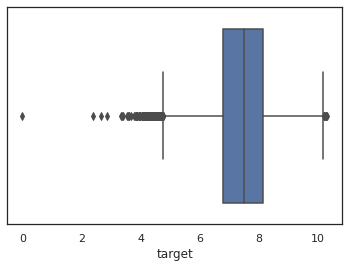

In [10]:
sns.boxplot(data=train, x='target')

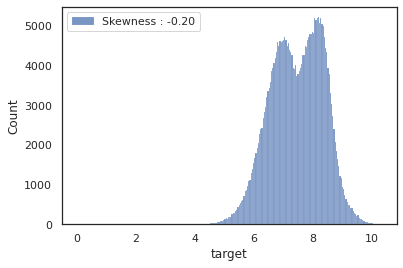

In [11]:
g= sns.histplot(data=train, x='target', label="Skewness : %.2f"%(train["target"].skew()))
g.legend()

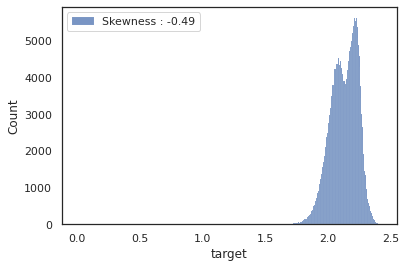

In [12]:
g = sns.histplot(np.log1p(train['target']), label="Skewness : %.2f"%(np.log1p(train["target"]).skew()))
g.legend()

# Outlier Detection

In [13]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    #outlier_indices = Counter(outlier_indices)    
    #multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    #return multiple_outliers 
    
    return outlier_indices

In [14]:
target_outliers = detect_outliers(train, 1, ["target"])
print(len(target_outliers))

359


In [15]:
train_copy = train.copy()
train.drop(target_outliers, axis=0, inplace=True)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299641 entries, 1 to 499999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    299641 non-null  object 
 1   cat1    299641 non-null  object 
 2   cat2    299641 non-null  object 
 3   cat3    299641 non-null  object 
 4   cat4    299641 non-null  object 
 5   cat5    299641 non-null  object 
 6   cat6    299641 non-null  object 
 7   cat7    299641 non-null  object 
 8   cat8    299641 non-null  object 
 9   cat9    299641 non-null  object 
 10  cont0   299641 non-null  float64
 11  cont1   299641 non-null  float64
 12  cont2   299641 non-null  float64
 13  cont3   299641 non-null  float64
 14  cont4   299641 non-null  float64
 15  cont5   299641 non-null  float64
 16  cont6   299641 non-null  float64
 17  cont7   299641 non-null  float64
 18  cont8   299641 non-null  float64
 19  cont9   299641 non-null  float64
 20  cont10  299641 non-null  float64
 21  cont11  29

# Feature Engineering and Selections

## 1. Categorical Features: Labeling

In [17]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
data =  pd.concat(objs=[train, test], axis=0)

### 1.1. Label Encoder

In [18]:
categorical_features = ['cat' + str(i) for i in range(10)]
for feature in categorical_features:
    encoder = LabelEncoder()
    encoder.fit(data[feature].values)
    data[feature] = encoder.transform(data[feature].values)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499641 entries, 1 to 499995
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    499641 non-null  int64  
 1   cat1    499641 non-null  int64  
 2   cat2    499641 non-null  int64  
 3   cat3    499641 non-null  int64  
 4   cat4    499641 non-null  int64  
 5   cat5    499641 non-null  int64  
 6   cat6    499641 non-null  int64  
 7   cat7    499641 non-null  int64  
 8   cat8    499641 non-null  int64  
 9   cat9    499641 non-null  int64  
 10  cont0   499641 non-null  float64
 11  cont1   499641 non-null  float64
 12  cont2   499641 non-null  float64
 13  cont3   499641 non-null  float64
 14  cont4   499641 non-null  float64
 15  cont5   499641 non-null  float64
 16  cont6   499641 non-null  float64
 17  cont7   499641 non-null  float64
 18  cont8   499641 non-null  float64
 19  cont9   499641 non-null  float64
 20  cont10  499641 non-null  float64
 21  cont11  49

## 2. Train and Test sets preparation

In [20]:
train_ohe = data[:train_len]
test_ohe  = data[train_len:]

In [21]:
test_ohe.drop('target', axis=1, inplace=True)

In [22]:
target = train_ohe.pop('target')

## 2.1. Standardization

In [23]:
scaler = StandardScaler()
scaler.fit(train_ohe)
train_scaled = scaler.transform(train_ohe)
test_scaled  = scaler.transform(test_ohe)

## 2.2. Train, Validation, Test sets

X_train, X_test, y_train, y_test = train_test_split(train_ohe, target, test_size=0.20)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_scaled, target, test_size=0.20)

# ML Model 

## 1. Light GBM

In [25]:
import lightgbm
from lightgbm import LGBMRegressor

In [35]:
from sklearn.utils import shuffle

n_training = 100000

X_train_rand, y_train_rand = shuffle(X_train, y_train, random_state=56)
X_train_p = X_train_rand[:n_training]
y_train_p = y_train_rand[:n_training]

test_size = 5000

nbins = (train_len - n_training)//test_size
remainder = (train_len - n_training)%test_size

print(nbins, remainder)

X_test_list = []
y_test_list = []

for i in range(nbins):
    X_test_p  = X_train_rand[n_training+test_size*i:n_training+test_size*(i+1)]
    y_test_p  = y_train_rand[n_training+test_size*i:n_training+test_size*(i+1)]
    
    X_test_list.append(X_test_p)
    y_test_list.append(y_test_p)

39 4641


## 3.1. Light GBM [default]

In [36]:
lgbm_reg = LGBMRegressor(n_estimators=300)
%time scores = cross_val_score(lgbm_reg, X_train_p, y_train_p, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rmse_list = np.sqrt(-scores)
print(np.round(rmse_list,4))
print(np.round(np.mean(rmse_list),4))

CPU times: user 85.8 ms, sys: 156 ms, total: 242 ms
Wall time: 5.76 s
[0.8486 0.8405 0.8349 0.8525 0.852  0.8458 0.8445 0.848  0.8331 0.8452]
0.8445


In [37]:
lgbm_reg = LGBMRegressor(n_estimators=300)
lgbm_reg.fit(X_train_p, y_train_p,verbose=100)

LGBMRegressor(n_estimators=300)

In [38]:
for i in range(15):
    pred = lgbm_reg.predict(X_test_list[i])
    print(np.round(rmse(y_test_list[i], pred),4))

0.848
0.8323
0.8456
0.842
0.8427
0.8514
0.8401
0.8386
0.848
0.8422
0.859
0.8411
0.8446
0.8382
0.8331


In [39]:
print(np.round(np.mean(rmse_list),4), np.round(np.std(rmse_list),4))

0.8445 0.0062


In [79]:
X_test_list[35]

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,
367490,0,0,1,2,1,1,0,4,2,6,...,0.280483,0.385085,0.348651,0.250480,0.413385,0.367807,0.357315,0.234222,0.353337,0.418720
206149,0,1,0,0,1,1,0,4,2,5,...,0.886374,0.418585,0.440001,0.337723,0.442551,0.394679,0.299476,0.383967,0.359291,0.801495
36842,0,0,0,2,1,3,0,4,4,8,...,0.305516,0.398774,0.359414,0.292139,0.210390,0.615887,0.437725,0.340588,0.463376,0.310506
421605,0,1,1,2,1,1,0,3,2,11,...,0.417655,0.372389,0.318900,0.587186,0.285130,0.490414,0.264030,0.321524,0.340100,0.469058
366859,0,1,0,2,1,1,0,4,4,5,...,0.741661,0.380508,0.287389,0.255087,0.299669,0.540102,0.259099,0.206325,0.285140,0.633759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131742,1,1,0,2,1,3,1,4,6,7,...,0.722072,0.807024,0.699308,0.623601,0.575714,0.618508,0.548232,0.540742,0.775626,0.813630
27345,0,0,0,0,1,3,0,4,6,8,...,0.536170,0.959647,0.586131,0.858822,0.923304,0.808019,0.628674,0.589716,0.858104,0.793321
168087,0,0,0,0,1,3,0,4,2,8,...,0.243653,0.173773,0.214459,0.342733,0.195121,0.305414,0.151381,0.181758,0.297679,0.359205


## 3.2. Hyper Parameter Tuning

In [82]:
help(LGBMRegressor)

Help on class LGBMRegressor in module lightgbm.sklearn:

class LGBMRegressor(LGBMModel, sklearn.base.RegressorMixin)
 |  LightGBM regressor.
 |  
 |  Method resolution order:
 |      LGBMRegressor
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.RegressorMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', categorical_feature='auto', callbacks=None, init_model=None)
 |      Build a gradient boosting model from the training set (X, y).
 |      
 |      Parameters
 |      ----------
 |      X : array-like or sparse matrix of shape = [n_samples, n_features]
 |          Input feature matrix.
 |      y : array-like of shape = [n_samples]
 |          The target values (class labels in classification, real numbers in regression).
 |      samp

In [184]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[100],            # default 
          'learning_rate':[0.1],           # default
          'reg_lambda':[0.0],              # default
          'reg_alpha':[0.0],               # default
          'num_leaves':[31],
          'min_child_samples':[5, 10, 20, 30],
          'max_depth':[5]
         }

lgbm_reg = LGBMRegressor()
grid_model = GridSearchCV(estimator=lgbm_reg, param_grid=params, scoring='neg_mean_squared_error',
                          cv=10, return_train_score=True, n_jobs=-1, verbose=3)
%time grid_model.fit(X_train_p, y_train_p)
print(np.sqrt(-1*grid_model.best_score_))
print(grid_model.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
CPU times: user 7.29 s, sys: 61.7 ms, total: 7.35 s
Wall time: 42.5 s
0.849141405836849
{'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 0.0}


In [157]:
from sklearn.model_selection import GridSearchCV

max_depth = 5
num_leaves = [10, 20, 30]

for num_leave in num_leaves:
    params = {'n_estimators':100,            # default 
              'learning_rate':0.1,           # default
              'reg_lambda':0.0,              # default
              'reg_alpha':0.0,               # default
              'num_leaves':num_leave,
              'min_child_samples':20,
              'max_depth':max_depth}

    lgbm_reg = LGBMRegressor(**params)
    scores = cross_val_score(lgbm_reg, X_train_p, y_train_p, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

    rmse_list = np.sqrt(-scores)
    
    print("{0:5d}".format(num_leave), end=" : ")
    print(np.round(rmse_list,4), end=" -> ")
    print("{0:.7f}, {1:.7f}".format(rmse_list.mean(), rmse_list.std())) 

   10 : [0.8573 0.8491 0.846  0.8417 0.8499 0.8572 0.8476 0.8429 0.8549 0.8575] -> 0.8503999, 0.0057127
   20 : [0.8561 0.8487 0.8445 0.8417 0.8487 0.8565 0.8478 0.841  0.8546 0.8553] -> 0.8494856, 0.0055908
   30 : [0.8571 0.8491 0.8458 0.8403 0.8484 0.8558 0.8479 0.842  0.8549 0.8567] -> 0.8497953, 0.0058151


In [162]:
lgbm_reg = LGBMRegressor(**params)
lgbm_reg.fit(X_train_p, y_train_p)

LGBMRegressor(max_depth=15)

In [163]:
rmse_list = []
for i in range(36):
    pred = lgbm_reg.predict(X_test_list[i])
    score = rmse(y_test_list[i], pred)
    rmse_list.append(score)
    print(np.round(score,4))

0.8489
0.8424
0.8389
0.849
0.8666
0.8649
0.8459
0.8456
0.8482
0.8473
0.845
0.8399
0.8474
0.847
0.8609
0.8437
0.8446
0.8536
0.8438
0.8494
0.8548
0.8587
0.8475
0.8408
0.8373
0.8601
0.8616
0.8522
0.8451
0.8615
0.8533
0.8481
0.8559
0.8619
0.8516
0.8523


In [164]:
print(np.round(np.mean(rmse_list),4), np.round(np.std(rmse_list),4))

0.8504 0.0075


## 3.3. HyperOpt

In [26]:
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

In [27]:
random_state = 89
n_iter = 50

In [30]:
from sklearn.utils import shuffle

n_training = 80000

X_train_rand, y_train_rand = shuffle(X_train, y_train, random_state=56)
X_train_p = X_train_rand[:n_training]
y_train_p = y_train_rand[:n_training]

test_size = 5000

nbins = (train_len - n_training)//test_size
remainder = (train_len - n_training)%test_size

print(nbins, remainder)

X_test_list = []
y_test_list = []

for i in range(nbins):
    X_test_p  = X_train_rand[n_training+test_size*i:n_training+test_size*(i+1)]
    y_test_p  = y_train_rand[n_training+test_size*i:n_training+test_size*(i+1)]
    
    X_test_list.append(X_test_p)
    y_test_list.append(y_test_p)

43 4641


In [31]:
def gb_mse_cv(params, random_state=random_state, cv=5, X=X_train_p, y=y_train_p):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
              'learning_rate': params['learning_rate'],
              'reg_lambda':params['reg_lambda'],
              'reg_alpha':params['reg_alpha'],
              'num_leaves':int(params['num_leaves']),
              'min_data_in_leaf':int(params['min_data_in_leaf']),
              'subsample':params['subsample'],
              'colsample_bytree':params['colsample_bytree'],
              }
    
    # we use this params to create a new LGBM Regressor
    model = LGBMRegressor(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean())

    return score

In [ ]:
%%time

# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 14000, 15001, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 60, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 100, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials,    # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'],
                      reg_lambda=best['reg_lambda'], reg_alpha=best['reg_alpha'],
                      num_leaves=int(best['num_leaves']), min_child_samples=int(best['min_data_in_leaf']),
                      subsample=best['subsample'], colsample_bytree=best['colsample_bytree'])

model.fit(X_train_p, y_train_p)
tpe_test_score=mean_squared_error(y_test, model.predict(X_test))

print("Best MSE {:.5f} params {}".format( gb_mse_cv(best), best))

 10%|█         | 5/50 [08:39<1:12:54, 97.21s/trial, best loss: 0.8519365862651356] 

In [ ]:
%%time

# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 10000, 15001, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 60, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 100, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=n_iter, # maximum number of iterations
          trials=trials,    # logging
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
         )

# computing the score on the test set
model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                      max_depth=int(best['max_depth']),learning_rate=best['learning_rate'],
                      reg_lambda=best['reg_lambda'], reg_alpha=best['reg_alpha'],
                      num_leaves=int(best['num_leaves']), min_child_samples=int(best['min_data_in_leaf']),
                      subsample=best['subsample'], colsample_bytree=best['colsample_bytree'])
model.fit(X_train, y_train)
tpe_test_score=mean_squared_error(y_test, model.predict(X_test))

print("Best MSE {:.5f} params {}".format( gb_mse_cv(best), best))

  4%|▍         | 2/50 [07:43<3:10:59, 238.75s/trial, best loss: 0.846651939881625]

### Trial 1
- Outlier detection (on target)
- labeling
- 60,000 training set
- 5,000 test size -> 0.8423 0.0075
```python
params = {'learning_rate': 0.17957032242242574, 'max_depth': 2, 
          'min_child_samples': 11, 'n_estimators': 418, 'num_leaves': 53, 
          'reg_alpha': 0.16752893978266326, 'reg_lambda': 0.014467774532165297}
```


### Trial 2
- HyperOpt Summary
----
```python
# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 100, 500, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 30, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 60, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }
```
----
100%|██████████| 100/100 [03:15<00:00,  1.96s/trial, best loss: 0.8436989876974101]<br>
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).<br>
Best MSE 0.84370 params {'colsample_bytree': 0.2282732724155444, 'learning_rate': 0.02537429421939708, 'max_depth': 22.0, 'min_data_in_leaf': 29.0, 'n_estimators': 453.0, 'num_leaves': 33.0, 'reg_alpha': 0.14557883706335378, 'reg_lambda': 2.6761465838395098, 'subsample': 0.13141616637831394}<br>
CPU times: user 26.4 s, sys: 944 ms, total: 27.3 s
Wall time: 3min 19s

-----
- Outlier detection (on target)
- labeling
- 60,000 training set
- 5,000 test size -> 0.8419 0.0072
```python
params = {'colsample_bytree': 0.2282732724155444, 'learning_rate': 0.02537429421939708, 'max_depth': 22,
          'min_child_samples': 29, 'n_estimators': 453, 'num_leaves': 33, 
          'reg_alpha': 0.14557883706335378,
          'reg_lambda': 2.6761465838395098, 'subsample': 0.13141616637831394}
```

### Trial 3
- HyperOpt Summary
----
```python
# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 100, 1000, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 30, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 60, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }
```
----
100%|██████████| 150/150 [07:37<00:00,  3.05s/trial, best loss: 0.8434295211075982]<br>
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).<br>
Best MSE 0.84343 params {'colsample_bytree': 0.2178533621419123, 'learning_rate': 0.03886611341034605, 'max_depth': 15.0, 'min_data_in_leaf': 29.0, 'n_estimators': 336.0, 'num_leaves': 39.0, 'reg_alpha': 0.01541717909533164, 'reg_lambda': 0.9784795209001725, 'subsample': 0.5705714265120603}<br>
CPU times: user 23.9 s, sys: 1.58 s, total: 25.5 s<br>
Wall time: 7min 40s

-----
- Outlier detection (on target)
- labeling
- 60,000 training set
- 5,000 test size -> 0.8419 0.0072
```python
params = {'colsample_bytree': 0.2178533621419123, 'learning_rate': 0.03886611341034605, 'max_depth': 15,
          'min_child_samples': 29, 'n_estimators': 336, 'num_leaves': 39, 
          'reg_alpha': 0.01541717909533164,
          'reg_lambda': 0.9784795209001725, 'subsample': 0.5705714265120603}
```

### Trial 4
- HyperOpt Summary
----
```python
# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 100, 1000, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 30, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 60, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }
```
----
100%|██████████| 200/200 [11:46<00:00,  3.53s/trial, best loss: 0.8428714641133203]<br>
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).<br>
Best MSE 0.84287 params {'colsample_bytree': 0.21193134480710185, 'learning_rate': 0.02791328861118218, 'max_depth': 30.0, 'min_data_in_leaf': 24.0, 'n_estimators': 699.0, 'num_leaves': 38.0, 'reg_alpha': 0.7516233031902478, 'reg_lambda': 0.12768412791860909, 'subsample': 0.44785906184366764}<br>
CPU times: user 49 s, sys: 2.26 s, total: 51.3 s<br>
Wall time: 11min 53s<br><br>

-----
- Outlier detection (on target)
- labeling
- 80,000 training set
- 2,000 test size -> 0.839988 0.010031
```python
params = {'colsample_bytree': 0.21193134480710185, 'learning_rate': 0.02791328861118218, 
          'max_depth': 30, 
          'min_data_in_leaf': 24, 'n_estimators': 699, 
          'num_leaves': 38, 'reg_alpha': 0.7516233031902478,
          'reg_lambda': 0.12768412791860909, 'subsample': 0.44785906184366764}
```

### Trial 5
- HyperOpt Summary
----
```python
# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 100, 1000, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 30, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 60, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }
```
----
100%|██████████| 500/500 [41:54<00:00,  5.03s/trial, best loss: 0.842839724709443] <br>
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).<br>
Best MSE 0.84284 params {'colsample_bytree': 0.18835274575394018, 'learning_rate': 0.01808512006317544, 'max_depth': 12.0, 'min_data_in_leaf': 12.0, 'n_estimators': 911.0, 'num_leaves': 39.0, 'reg_alpha': 1.6752793152659506, 'reg_lambda': 0.02312180453588367, 'subsample': 0.548717592948858}<br>
CPU times: user 1min 46s, sys: 5.85 s, total: 1min 52s<br>
Wall time: 42min 4s<br><br>

-----
- Outlier detection (on target)
- labeling
- 80,000 training set
- 4,000 test size -> 0.839075 0.006181
```python
params = {'colsample_bytree': 0.18835274575394018, 'learning_rate': 0.01808512006317544,
          'max_depth': 12, 'min_data_in_leaf': 12, 'n_estimators': 911, 
          'num_leaves': 39, 'reg_alpha': 1.6752793152659506, 'reg_lambda': 0.02312180453588367, 
          'subsample': 0.548717592948858}
```

### Trial 6
- HyperOpt Summary
----
```python
# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 100, 1000, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 30, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 60, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }
```
----
100%|██████████| 100/100 [10:12<00:00,  6.13s/trial, best loss: 0.842250477722646]<br>
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).<br>
Best MSE 0.84225 params {'colsample_bytree': 0.19308899372753213, 'learning_rate': 0.010499495078595792, 'max_depth': 16.0, 'min_data_in_leaf': 29.0, 'n_estimators': 998.0, 'num_leaves': 74.0, 'reg_alpha': 0.09898689568161717, 'reg_lambda': 0.061882969295189987, 'subsample': 0.3066138036111073}<br>
CPU times: user 1min 18s, sys: 1.68 s, total: 1min 19s<br>
Wall time: 10min 30s<br><br>

-----
- Outlier detection (on target)
- labeling
- 100,000 training set
- 2,000 test size -> 0.837339 0.008455
```python
params = {'colsample_bytree': 0.19308899372753213, 'learning_rate': 0.010499495078595792,
          'max_depth': 16, 'min_child_samples': 29, 'n_estimators': 998,
          'num_leaves': 74, 'reg_alpha': 0.09898689568161717, 
          'reg_lambda': 0.061882969295189987, 'subsample': 0.3066138036111073}
```

### Trial 7
- HyperOpt Summary
----
```python
# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 100, 1000, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 60, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 150, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }
```
----
100%|██████████| 1000/1000 [2:09:22<00:00,  7.76s/trial, best loss: 0.8413273248440909] <br>
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Best MSE 0.84133 params {'colsample_bytree': 0.18933481518883086, 'learning_rate': 0.021833601579879187, 'max_depth': 40.0, 'min_data_in_leaf': 22.0, 'n_estimators': 999.0, 'num_leaves': 60.0, 'reg_alpha': 2.3020147629507846, 'reg_lambda': 0.02814622327390729, 'subsample': 0.49378031804432754} <br>
CPU times: user 3min 33s, sys: 14.3 s, total: 3min 47s <br>
Wall time: 2h 9min 36s <br> <br>

-----
- Outlier detection (on target)
- labeling
- 120,000 training set
- 2,000 test size -> 0.838006 0.010427
```python
params = {'colsample_bytree': 0.18933481518883086, 'learning_rate': 0.021833601579879187, 
          'max_depth': 40, 'min_child_samples': 22, 'n_estimators': 999, 
          'num_leaves': 60, 'reg_alpha': 2.3020147629507846, 
          'reg_lambda': 0.02814622327390729, 'subsample': 0.49378031804432754}
```

### Trial 8
- HyperOpt Summary
----
```python
# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 1000, 2000, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 60, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 150, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }
```
----
100%|██████████| 500/500 [2:11:36<00:00, 15.79s/trial, best loss: 0.8405452483687094] <br> 
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).<br>
Best MSE 0.84055 params {'colsample_bytree': 0.22876399920867524, 'learning_rate': 0.018672086995304846, 'max_depth': 21.0, 'min_data_in_leaf': 16.0, 'n_estimators': 1107.0, 'num_leaves': 55.0, 'reg_alpha': 2.2614137917648516, 'reg_lambda': 0.03690844262153787, 'subsample': 0.16174281439412969}<br>
CPU times: user 1min 58s, sys: 8.47 s, total: 2min 6s<br>
Wall time: 2h 11min 55s<br><br>

-----
- Outlier detection (on target)
- labeling
- 150,000 training set
- 5,000 test size -> 0.836022 0.007318
```python
params = {'colsample_bytree': 0.22876399920867524, 'learning_rate': 0.018672086995304846,
          'max_depth': 21, 'min_child_samples': 16, 'n_estimators': 1107,
          'num_leaves': 55, 'reg_alpha': 2.2614137917648516, 
          'reg_lambda': 0.03690844262153787, 'subsample': 0.16174281439412969}
```

### Trial 9
- HyperOpt Summary
----
```python
# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 500, 1500, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 60, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 100, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }
```
----
100%|██████████| 1000/1000 [4:53:27<00:00, 17.61s/trial, best loss: 0.8389699315378036] <br>
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).<br>
Best MSE 0.83897 params {'colsample_bytree': 0.20649580746482601, 'learning_rate': 0.014557653231650912, 'max_depth': 21.0, 'min_data_in_leaf': 8.0, 'n_estimators': 1499.0, 'num_leaves': 64.0, 'reg_alpha': 1.9101930497563555, 'reg_lambda': 0.035354628609059344, 'subsample': 0.2355497548249499}<br>
CPU times: user 4min 5s, sys: 20.6 s, total: 4min 25s<br>
Wall time: 4h 53min 59s<br><br>

-----
- Outlier detection (on target)
- labeling
- 180,000 training set
- 2,000 test size -> 0.836943 0.010106
```python
params = {'colsample_bytree': 0.20649580746482601, 'learning_rate': 0.014557653231650912, 
          'max_depth': 21, 'min_child_samples': 8, 'n_estimators': 1499, 
          'num_leaves': 64, 'reg_alpha': 1.9101930497563555, 'reg_lambda': 0.035354628609059344, 
          'subsample': 0.2355497548249499}
```

### Trial 10
- HyperOpt Summary
----
```python
# possible values of parameters
space={'n_estimators'     : hp.quniform('n_estimators', 3000, 5001, 1),
       'max_depth'        : hp.quniform('max_depth', 2, 60, 1),
       'learning_rate'    : hp.loguniform('learning_rate', -5, 0),
       'reg_lambda'       : hp.loguniform('reg_lambda', -5, 1),
       'reg_alpha'        : hp.loguniform('reg_alpha', -5, 1),
       'num_leaves'       : hp.quniform('num_leaves', 31, 100, 1),
       'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 5, 30, 1),
       'subsample'        : hp.uniform('subsample', 0, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
      }
```
----
100%|██████████| 50/50 [1:12:58<00:00, 87.57s/trial, best loss: 0.8374116284172376]<br>
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).<br>
Best MSE 0.83741 params {'colsample_bytree': 0.20960685817160332, 'learning_rate': 0.009345211157774008, 'max_depth': 17.0, 'min_data_in_leaf': 12.0, 'n_estimators': 3903.0, 'num_leaves': 99.0, 'reg_alpha': 2.513813203771358, 'reg_lambda': 0.03397821313697652, 'subsample': 0.7447271582115403}<br>
CPU times: user 5min 15s, sys: 1.93 s, total: 5min 17s<br>
Wall time: 1h 15min 25s<br><br>

-----
- Outlier detection (on target)
- labeling
- 280,000 training set
- 1,000 test size ->
```python
params = {'colsample_bytree': 0.20960685817160332, 'learning_rate': 0.009345211157774008,
          'max_depth': 17., 'min_child_samples': 12, 'n_estimators': 3903, 
          'num_leaves': 99, 'reg_alpha': 2.513813203771358, 
          'reg_lambda': 0.03397821313697652, 'subsample': 0.7447271582115403}
```

In [40]:
rmse_list = []
params = {'colsample_bytree': 0.20960685817160332, 'learning_rate': 0.009345211157774008,
        'max_depth': 17, 'min_child_samples': 12, 'n_estimators': 3903, 
        'num_leaves': 99, 'reg_alpha': 2.513813203771358, 
        'reg_lambda': 0.03397821313697652, 'subsample': 0.7447271582115403}

lgbm_reg = LGBMRegressor(**params)
lgbm_reg.fit(X_train_p, y_train_p)

LGBMRegressor(colsample_bytree=0.20960685817160332,
              learning_rate=0.009345211157774008, max_depth=17,
              min_child_samples=12, n_estimators=3903, num_leaves=99,
              reg_alpha=2.513813203771358, reg_lambda=0.03397821313697652,
              subsample=0.7447271582115403)

In [42]:
for i in range(3):
    pred = lgbm_reg.predict(X_test_list[i])
    score = rmse(y_test_list[i], pred)
    rmse_list.append(score)
    print(np.round(score,4))

ValueError: Found array with 0 sample(s) (shape=(0, 24)) while a minimum of 1 is required.

In [33]:
print(np.round(np.mean(rmse_list),6), np.round(np.std(rmse_list),6))

0.836943 0.010106


----------------

In [227]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error

In [228]:
# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [229]:
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [ ]:
obj = HPOpt(X_train_p, X_test, y_train_p, y_test)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

## 3.3. Predictions

In [43]:
predictions = lgbm_reg.predict(test_scaled)

--------------

# Submit

In [44]:
submission = pd.read_csv("./input/sample_submission.csv")
submission["target"] = predictions

print(submission.shape)
submission.head()

(200000, 2)


,id,target
0,0,7.624497
1,5,7.764095
2,15,7.599630
3,16,7.533666
4,17,7.234053


In [45]:
submission.to_csv("./score_submission_02212021_ver13_lgbm_hyperopt_0.83741.csv", index=False)